In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [96]:
# Function to parse a string into a NumPy array
def parse_vector_string(vector_string):
    # Check if the input is a float (for cases where the vector is already a number)
    if isinstance(vector_string, float):
        return np.array([vector_string], dtype=np.float32)

    # Remove the square brackets and split the values by space
    values = vector_string.strip('[]').split()
    # Ensure that the vector has a consistent length (you can modify this condition)
    if len(values) == YOUR_VECTOR_LENGTH:
        # Convert the values to floats and create a NumPy array
        vector = np.array([float(value) for value in values], dtype=np.float32)
        return vector
    else:
        # Handle invalid vectors (e.g., return an array of zeros or NaN)
        return np.zeros(YOUR_VECTOR_LENGTH, dtype=np.float32)

In [97]:
# Load your CSV file
data = pd.read_csv('Final_Vectorised_Dataset.csv')

# Define the expected length of your vectors
YOUR_VECTOR_LENGTH = 3041  # Modify this to the actual length of your vectors

# Assuming the CSV file has a column 'Title_Vector' containing vector strings
requirement_vectors = data['Title_Vector'].apply(parse_vector_string)

# Filter out entries with invalid vectors
requirement_vectors = requirement_vectors[requirement_vectors.apply(lambda x: x.shape == (YOUR_VECTOR_LENGTH,))]

In [98]:
# Extract the relevant columns
#requirement_vectors = data['Title_Vector'].values
complexity = data[['Lines of Code', 'Cyclomatic Complexity']].values
consequence = data[['Number of Calls', 'TBF', 'Reliability']].values

In [99]:
# Convert the filtered arrays to a NumPy array and normalize
requirement_vectors = np.array(requirement_vectors.tolist(), dtype=np.float32)
scaler = MinMaxScaler()
requirement_vectors = scaler.fit_transform(requirement_vectors)

# Normalize the numeric data (complexity and consequence)
complexity = scaler.fit_transform(complexity)
consequence = scaler.fit_transform(consequence)

In [100]:
# Split the data into training and testing sets
req_train, req_test, comp_train, comp_test, conseq_train, conseq_test = train_test_split(
    requirement_vectors, complexity, consequence, test_size=0.2)

In [101]:
# Build the autoencoder for the 3 main columns
input_layer = Input(shape=(YOUR_VECTOR_LENGTH,))
encoded = Dense(64, activation='relu')(input_layer)  # Adjust the layer sizes as needed
decoded = Dense(1, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [102]:
# Train the autoencoder
autoencoder.fit(req_train, req_train, epochs=100, batch_size=32, validation_data=(req_test, req_test))

Epoch 1/100
76/76 [==============================] - 1s 6ms/step - loss: 0.2408 - val_loss: 0.2315
Epoch 2/100
76/76 [==============================] - 0s 3ms/step - loss: 0.2228 - val_loss: 0.2141
Epoch 3/100
76/76 [==============================] - 0s 3ms/step - loss: 0.2059 - val_loss: 0.1978
Epoch 4/100
76/76 [==============================] - 0s 3ms/step - loss: 0.1902 - val_loss: 0.1826
Epoch 5/100
76/76 [==============================] - 0s 3ms/step - loss: 0.1756 - val_loss: 0.1686
Epoch 6/100
76/76 [==============================] - 0s 6ms/step - loss: 0.1621 - val_loss: 0.1556
Epoch 7/100
76/76 [==============================] - 0s 3ms/step - loss: 0.1496 - val_loss: 0.1436
Epoch 8/100
76/76 [==============================] - 0s 3ms/step - loss: 0.1381 - val_loss: 0.1326
Epoch 9/100
76/76 [==============================] - 0s 5ms/step - loss: 0.1276 - val_loss: 0.1225
Epoch 10/100
76/76 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.1133
Epoch 11/

76/76 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 84/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 85/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 86/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 87/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 88/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 89/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 90/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 91/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 92/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 93/100


In [103]:
# Calculate MSE and show as a percentage
mse = np.mean(np.square(req_test - autoencoder.predict(req_test)))
percentage_mse = mse * 100

print(f'Mean Square Error as Percentage: {percentage_mse:.2f}%')

20/20 [==============================] - 0s 1ms/step
Mean Square Error as Percentage: 0.12%


In [104]:
# Calculate Mean Absolute Error (AE) for the compressed representation
ae = np.mean(np.abs(req_test - autoencoder.predict(req_test)))
percentage_ae = ae * 100

print(f'Mean Absolute Error as Percentage: {percentage_ae:.2f}%')


20/20 [==============================] - 0s 1ms/step
Mean Absolute Error as Percentage: 3.53%


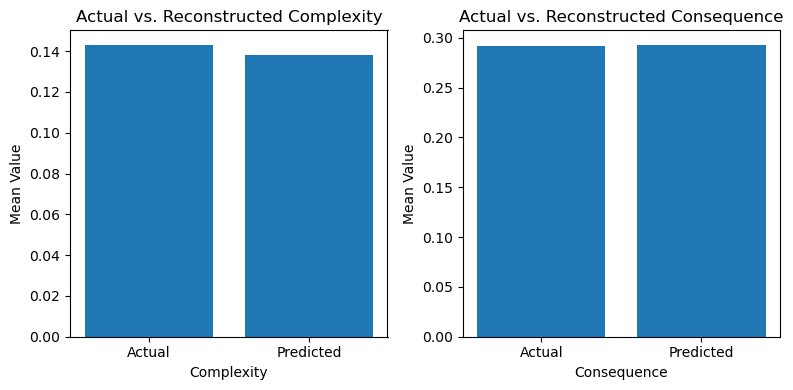

In [105]:
# Visualize the predicted output for "time" and "cost" using bar graphs
plt.figure(figsize=(8, 4))

# Visualize "complexity" using a bar graph
plt.subplot(1, 2, 1)
plt.bar(['Actual', 'Predicted'], [np.mean(complexity), np.mean(comp_test)])
plt.xlabel("Complexity")
plt.ylabel("Mean Value")
plt.title("Actual vs. Reconstructed Complexity")

# Visualize "consequence" using a bar graph
plt.subplot(1, 2, 2)
plt.bar(['Actual', 'Predicted'], [np.mean(consequence), np.mean(conseq_test)])
plt.xlabel("Consequence")
plt.ylabel("Mean Value")
plt.title("Actual vs. Reconstructed Consequence")

plt.tight_layout()
plt.show() 

In [115]:
# Calculate MSE for complexity
mse_complexity = np.mean(np.square(comp_test - predicted_complexity))
percentage_mse_complexity = mse_complexity * 100

print(f'Reconstruction Mean Squared Error (MSE) for Complexity as Percentage: {percentage_mse_complexity:.2f}%')

# Calculate MSE for consequences
mse_consequences = np.mean(np.square(conseq_test - predicted_consequences))
percentage_mse_consequences = mse_consequences * 100

print(f'Reconstruction Mean Squared Error (MSE) for Consequences as Percentage: {percentage_mse_consequences:.2f}%')


Reconstruction Mean Squared Error (MSE) for Complexity as Percentage: 4.93%
Reconstruction Mean Squared Error (MSE) for Consequences as Percentage: 4.15%


In [117]:
# Calculate MAE for complexity
mae_complexity = np.mean(np.abs(comp_test - predicted_complexity))
percentage_mae_complexity = mae_complexity * 100

print(f'Reconstruction Mean Absolute Error (MAE) for Complexity as Percentage: {percentage_mae_complexity:.2f}%')

# Calculate MAE for consequences
mae_consequences = np.mean(np.abs(conseq_test - predicted_consequences))
percentage_mae_consequences = mae_consequences * 100

print(f'Reconstruction Mean Absolute Error (MAE) for Consequences as Percentage: {percentage_mae_consequences:.2f}%')


Reconstruction Mean Absolute Error (MAE) for Complexity as Percentage: 14.30%
Reconstruction Mean Absolute Error (MAE) for Consequences as Percentage: 12.69%


In [106]:
# Create a new model to get the compressed representation from the autoencoder
compressed_representation_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
compressed_train_data = compressed_representation_model.predict(req_train)
compressed_test_data = compressed_representation_model.predict(req_test)

# Build the bijective mapping model
bijective_input = Input(shape=(64,))  # Use the correct input shape (64 units)
bijective_output = Dense(2, activation='linear')(bijective_input)
bijective_model = Model(bijective_input, bijective_output)
bijective_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the bijective mapping model on the training data
bijective_model.fit(compressed_train_data, comp_train, epochs=100, batch_size=32, validation_data=(compressed_test_data, comp_test))

# Predict complexity values on the validation set
compressed_validation_data = compressed_representation_model.predict(req_test)  # Get compressed data
predicted_complexity = bijective_model.predict(compressed_validation_data)

20/20 [==============================] - 0s 1ms/step
Epoch 1/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0679 - val_loss: 0.0546
Epoch 2/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0502
Epoch 3/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0494
Epoch 4/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0555 - val_loss: 0.0493
Epoch 5/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 6/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 7/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 8/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 9/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 10/100
76/76 [==============================] - 0s

Epoch 82/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 83/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 84/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 85/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 86/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 87/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0494
Epoch 88/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0555 - val_loss: 0.0494
Epoch 89/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 90/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 91/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0555 - val_loss: 0.0494


In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mse = mean_squared_error(comp_test, predicted_complexity)

# Calculate AE
ae = mean_absolute_error(comp_test, predicted_complexity)

# Calculate the percentage of MSE and AE relative to the range of your complexity values
range_of_complexity = np.max(comp_test) - np.min(comp_test)
percentage_mse = (mse / range_of_complexity) * 100
percentage_ae = (ae / range_of_complexity) * 100

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (AE): {ae:.2f}')
print(f'Mean Squared Error as Percentage: {percentage_mse:.2f}%')
print(f'Mean Absolute Error as Percentage: {percentage_ae:.2f}%')


Mean Squared Error (MSE): 0.05
Mean Absolute Error (AE): 0.14
Mean Squared Error as Percentage: 4.93%
Mean Absolute Error as Percentage: 14.30%


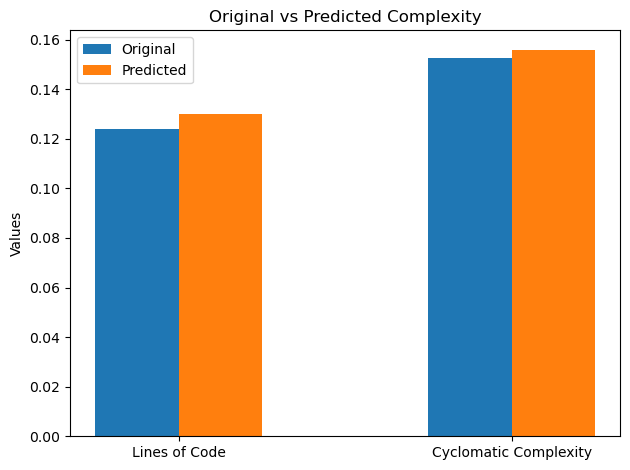

In [108]:
import matplotlib.pyplot as plt

# Extract 'Lines of Code' and 'Cyclomatic Complexity' from the test set
lines_of_code_original = comp_test[:, 0]
cyclomatic_complexity_original = comp_test[:, 1]

# Extract the predicted values
lines_of_code_predicted = predicted_complexity[:, 0]
cyclomatic_complexity_predicted = predicted_complexity[:, 1]

# Create a bar graph
labels = ['Lines of Code', 'Cyclomatic Complexity']
original_values = [lines_of_code_original.mean(), cyclomatic_complexity_original.mean()]
predicted_values = [lines_of_code_predicted.mean(), cyclomatic_complexity_predicted.mean()]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted')

ax.set_ylabel('Values')
ax.set_title('Original vs Predicted Complexity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


In [109]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for 'Lines of Code'
mse_lines_of_code = mean_squared_error(comp_test[:, 0], predicted_complexity[:, 0])

# Calculate MSE for 'Cyclomatic Complexity'
mse_cyclomatic_complexity = mean_squared_error(comp_test[:, 1], predicted_complexity[:, 1])

# Calculate the percentage of MSE relative to the range for 'Lines of Code'
range_lines_of_code = np.max(comp_test[:, 0]) - np.min(comp_test[:, 0])
percentage_mse_lines_of_code = (mse_lines_of_code / range_lines_of_code) * 100

# Calculate the percentage of MSE relative to the range for 'Cyclomatic Complexity'
range_cyclomatic_complexity = np.max(comp_test[:, 1]) - np.min(comp_test[:, 1])
percentage_mse_cyclomatic_complexity = (mse_cyclomatic_complexity / range_cyclomatic_complexity) * 100

print(f'Mean Squared Error (MSE) for Lines of Code as Percentage: {percentage_mse_lines_of_code:.2f}%')
print(f'Mean Squared Error (MSE) for Cyclomatic Complexity as Percentage: {percentage_mse_cyclomatic_complexity:.2f}%')



Mean Squared Error (MSE) for Lines of Code as Percentage: 5.01%
Mean Squared Error (MSE) for Cyclomatic Complexity as Percentage: 4.86%


In [110]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for 'Lines of Code'
mae_lines_of_code = mean_absolute_error(comp_test[:, 0], predicted_complexity[:, 0])

# Calculate MAE for 'Cyclomatic Complexity'
mae_cyclomatic_complexity = mean_absolute_error(comp_test[:, 1], predicted_complexity[:, 1])

# Calculate the percentage of MAE relative to the range for 'Lines of Code'
range_lines_of_code = np.max(comp_test[:, 0]) - np.min(comp_test[:, 0])
percentage_mae_lines_of_code = (mae_lines_of_code / range_lines_of_code) * 100

# Calculate the percentage of MAE relative to the range for 'Cyclomatic Complexity'
range_cyclomatic_complexity = np.max(comp_test[:, 1]) - np.min(comp_test[:, 1])
percentage_mae_cyclomatic_complexity = (mae_cyclomatic_complexity / range_cyclomatic_complexity) * 100

print(f'Mean Absolute Error (MAE) for Lines of Code as Percentage: {percentage_mae_lines_of_code:.2f}%')
print(f'Mean Absolute Error (MAE) for Cyclomatic Complexity as Percentage: {percentage_mae_cyclomatic_complexity:.2f}%')


Mean Absolute Error (MAE) for Lines of Code as Percentage: 14.41%
Mean Absolute Error (MAE) for Cyclomatic Complexity as Percentage: 14.19%


In [111]:
# Build the DNN for predicting consequences
conseq_input = Input(shape=(64,))  # Use the correct input shape (64 units, same as the compression layer)
conseq_layer = Dense(3, activation='linear')(conseq_input)  # 3 outputs for 'Number of Calls', 'TBF', and 'Reliability'
conseq_model = Model(conseq_input, conseq_layer)
conseq_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the consequences prediction model on the training data
conseq_model.fit(compressed_train_data, conseq_train, epochs=100, batch_size=32, validation_data=(compressed_test_data, conseq_test))

# Predict consequences on the validation set
predicted_consequences = conseq_model.predict(compressed_validation_data)

# Calculate the mean squared error (MSE) and mean absolute error (MAE) for the predicted consequences
mse_conseq = mean_squared_error(conseq_test, predicted_consequences)
mae_conseq = mean_absolute_error(conseq_test, predicted_consequences)

# Calculate the percentage of MSE and MAE relative to the range of your consequence values
range_of_conseq = np.max(conseq_test) - np.min(conseq_test)
percentage_mse_conseq = (mse_conseq / range_of_conseq) * 100
percentage_mae_conseq = (mae_conseq / range_of_conseq) * 100

print(f'Consequence Prediction Mean Squared Error (MSE): {mse_conseq:.2f}')
print(f'Consequence Prediction Mean Absolute Error (MAE): {mae_conseq:.2f}')
print(f'Consequence Prediction MSE as Percentage: {percentage_mse_conseq:.2f}%')
print(f'Consequence Prediction MAE as Percentage: {percentage_mae_conseq:.2f}%')


Epoch 1/100
76/76 [==============================] - 0s 3ms/step - loss: 0.2204 - val_loss: 0.2040
Epoch 2/100
76/76 [==============================] - 0s 2ms/step - loss: 0.1857 - val_loss: 0.1724
Epoch 3/100
76/76 [==============================] - 0s 1ms/step - loss: 0.1572 - val_loss: 0.1461
Epoch 4/100
76/76 [==============================] - 0s 2ms/step - loss: 0.1335 - val_loss: 0.1238
Epoch 5/100
76/76 [==============================] - 0s 1ms/step - loss: 0.1139 - val_loss: 0.1056
Epoch 6/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0978 - val_loss: 0.0907
Epoch 7/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0848 - val_loss: 0.0788
Epoch 8/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0745 - val_loss: 0.0692
Epoch 9/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0620
Epoch 10/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0563
Epoch 11/

76/76 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 84/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0414
Epoch 85/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 86/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 87/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 88/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 89/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 90/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 91/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0414
Epoch 92/100
76/76 [==============================] - 0s 1ms/step - loss: 0.0444 - val_loss: 0.0415
Epoch 93/100


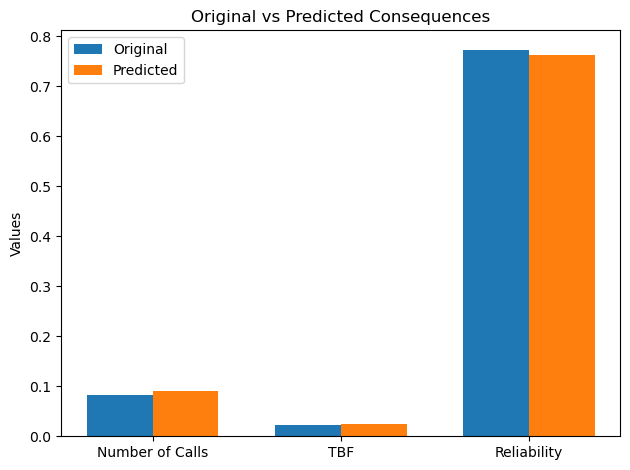

In [112]:
import matplotlib.pyplot as plt

# Extract 'Number of Calls', 'TBF', and 'Reliability' from the test set
num_calls_original = conseq_test[:, 0]
tbf_original = conseq_test[:, 1]
reliability_original = conseq_test[:, 2]

# Extract the predicted values
num_calls_predicted = predicted_consequences[:, 0]
tbf_predicted = predicted_consequences[:, 1]
reliability_predicted = predicted_consequences[:, 2]

# Create a bar graph
labels = ['Number of Calls', 'TBF', 'Reliability']
original_values = [num_calls_original.mean(), tbf_original.mean(), reliability_original.mean()]
predicted_values = [num_calls_predicted.mean(), tbf_predicted.mean(), reliability_predicted.mean()]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted')

ax.set_ylabel('Values')
ax.set_title('Original vs Predicted Consequences')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


In [113]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for 'Number of Calls'
mse_num_calls = mean_squared_error(conseq_test[:, 0], predicted_consequences[:, 0])

# Calculate MSE for 'TBF'
mse_tbf = mean_squared_error(conseq_test[:, 1], predicted_consequences[:, 1])

# Calculate MSE for 'Reliability'
mse_reliability = mean_squared_error(conseq_test[:, 2], predicted_consequences[:, 2])

# Calculate the percentage of MSE relative to the range for 'Number of Calls'
range_num_calls = np.max(conseq_test[:, 0]) - np.min(conseq_test[:, 0])
percentage_mse_num_calls = (mse_num_calls / range_num_calls) * 100

# Calculate the percentage of MSE relative to the range for 'TBF'
range_tbf = np.max(conseq_test[:, 1]) - np.min(conseq_test[:, 1])
percentage_mse_tbf = (mse_tbf / range_tbf) * 100

# Calculate the percentage of MSE relative to the range for 'Reliability'
range_reliability = np.max(conseq_test[:, 2]) - np.min(conseq_test[:, 2])
percentage_mse_reliability = (mse_reliability / range_reliability) * 100

print(f'Mean Squared Error (MSE) for Number of Calls as Percentage: {percentage_mse_num_calls:.2f}%')
print(f'Mean Squared Error (MSE) for TBF as Percentage: {percentage_mse_tbf:.2f}%')
print(f'Mean Squared Error (MSE) for Reliability as Percentage: {percentage_mse_reliability:.2f}%')


Mean Squared Error (MSE) for Number of Calls as Percentage: 1.37%
Mean Squared Error (MSE) for TBF as Percentage: 0.71%
Mean Squared Error (MSE) for Reliability as Percentage: 10.95%


In [114]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for 'Number of Calls'
mae_num_calls = mean_absolute_error(conseq_test[:, 0], predicted_consequences[:, 0])

# Calculate MAE for 'TBF'
mae_tbf = mean_absolute_error(conseq_test[:, 1], predicted_consequences[:, 1])

# Calculate MAE for 'Reliability'
mae_reliability = mean_absolute_error(conseq_test[:, 2], predicted_consequences[:, 2])

# Calculate the percentage of MAE relative to the range for 'Number of Calls'
range_num_calls = np.max(conseq_test[:, 0]) - np.min(conseq_test[:, 0])
percentage_mae_num_calls = (mae_num_calls / range_num_calls) * 100

# Calculate the percentage of MAE relative to the range for 'TBF'
range_tbf = np.max(conseq_test[:, 1]) - np.min(conseq_test[:, 1])
percentage_mae_tbf = (mae_tbf / range_tbf) * 100

# Calculate the percentage of MAE relative to the range for 'Reliability'
range_reliability = np.max(conseq_test[:, 2]) - np.min(conseq_test[:, 2])
percentage_mae_reliability = (mae_reliability / range_reliability) * 100

print(f'Mean Absolute Error (MAE) for Number of Calls as Percentage: {percentage_mae_num_calls:.2f}%')
print(f'Mean Absolute Error (MAE) for TBF as Percentage: {percentage_mae_tbf:.2f}%')
print(f'Mean Absolute Error (MAE) for Reliability as Percentage: {percentage_mae_reliability:.2f}%')


Mean Absolute Error (MAE) for Number of Calls as Percentage: 10.58%
Mean Absolute Error (MAE) for TBF as Percentage: 4.62%
Mean Absolute Error (MAE) for Reliability as Percentage: 27.26%
